# CLASIFICACIÓN DE LA READMICIÓN HOSPITALARIA DE PACIENTES DIABETICOS

#### Desarrollador: Juan Felipe León G
#### 06/02/2021

## 0. Importar librerias

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #borrar
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 1. Cargar data set

In [2]:
# Cargue de diabetic_data
path = os.path.join('c:' + os.sep, 'Users', 'n0306029', 'Desktop', 'dataset_diabetes', 'diabetic_data.csv')
diabetic_data = pd.read_csv(path)
print ("Diabetic_data read successfully")
print(diabetic_data)

Diabetic_data read successfully
        encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  disc

## 2. EDA y preparación de datos

### 2.1 Tratamiento de valores nulos

In [3]:
 #En el data set los valores nulos aparecen con el caracter "?" Acá se reemplazan los "?" por NaN.
diabetic_data = diabetic_data.replace("?",np.nan)

In [4]:
diabetic_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Se revisan las variables con una mayor proporción de valores nulos.
diabetic_data.info()
# Conteo de niveles unicos para cada variable
diabetic_data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

encounter_id                101766
patient_nbr                  71518
race                             5
gender                           3
age                             10
weight                           9
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
payer_code                      17
medical_specialty               72
num_lab_procedures             118
num_procedures                   7
num_medications                 75
number_outpatient               39
number_emergency                33
number_inpatient                21
diag_1                         716
diag_2                         748
diag_3                         789
number_diagnoses                16
max_glu_serum                    4
A1Cresult                        4
metformin                        4
repaglinide                      4
nateglinide                      4
chlorpropamide                   4
glimepiride         

### 2.2 Eliminación de variables inútiles

In [6]:
# Se descartan las columnas con cuya mayoria de registros tiene valor NaN y las variables con un (1) solo nivel
diabetic_data = diabetic_data.drop(['weight','payer_code','medical_specialty','examide','citoglipton'],axis=1)

### 2.3 Remapeo de variables

In [7]:
# Se etiqueta nuevamente la variable objetivo agrupando los dos casos de reingreso en una sola categoria
diabetic_data = diabetic_data.replace({"NO":0, "<30":1, ">30":1})

In [8]:
# Se etiqueta nuevamente la variable admission_type_id
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].replace({1:"Emergency",2:"Urgent",3:"Elective",4:"Newborn",5:np.nan,6:np.nan,7:"Trauma Center",8:np.nan,})

In [9]:
# Se etiqueta nuevamente la variable mapped_discharge
mapped_discharge = {1:"Discharged to Home",
                    6:"Discharged to Home",
                    8:"Discharged to Home",
                    13:"Discharged to Home",
                    19:"Discharged to Home",
                    18:np.nan,25:np.nan,26:np.nan,
                    2:"Other",3:"Other",4:"Other",
                    5:"Other",7:"Other",9:"Other",
                    10:"Other",11:"Other",12:"Other",
                    14:"Other",15:"Other",16:"Other",
                    17:"Other",20:"Other",21:"Other",
                    22:"Other",23:"Other",24:"Other",
                    27:"Other",28:"Other",29:"Other",30:"Other"}

In [10]:
diabetic_data["discharge_disposition_id"] = diabetic_data["discharge_disposition_id"].replace(mapped_discharge)

In [11]:
# Se etiqueta nuevamente la variable admission_source_id cambiando los códigos numericos por texto
mapped_adm = {1:"Referral",2:"Referral",3:"Referral",
              4:"Other",5:"Other",6:"Other",10:"Other",22:"Other",25:"Other",
              9:"Other",8:"Other",14:"Other",13:"Other",11:"Other",
              15:np.nan,17:np.nan,20:np.nan,21:np.nan,
              7:"Emergency"}

In [12]:
diabetic_data.admission_source_id = diabetic_data.admission_source_id.replace(mapped_adm)

In [13]:
#Tratamiento de diag_1, diag_2 y diag_3 dado que cada una tiene al rededor de 700 niveles
# Se define una funcion para mapear la cateogria del diagnostico al código
def map_diagnosis(data, cols):
    for col in cols:
        data.loc[(data[col].str.contains("V")) | (data[col].str.contains("E")), col] = -1
        data[col] = data[col].astype(np.float16)

    for col in cols:
        data["temp_diag"] = np.nan
        data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
        data.loc[(data[col]>=460) & (data[col]<=519) | (data[col]==786), "temp_diag"] = "Respiratory"
        data.loc[(data[col]>=520) & (data[col]<=579) | (data[col]==787), "temp_diag"] = "Digestive"
        data.loc[(data[col]>=250) & (data[col]<251), "temp_diag"] = "Diabetes"
        data.loc[(data[col]>=800) & (data[col]<=999), "temp_diag"] = "Injury"
        data.loc[(data[col]>=710) & (data[col]<=739), "temp_diag"] = "Muscoloskeletal"
        data.loc[(data[col]>=580) & (data[col]<=629) | (data[col] == 788), "temp_diag"] = "Genitourinary"
        data.loc[(data[col]>=140) & (data[col]<=239), "temp_diag"] = "Neoplasms"

        data["temp_diag"] = data["temp_diag"].fillna("Other")
        data[col] = data["temp_diag"]
        data = data.drop("temp_diag", axis=1)

    return data

In [14]:
diabetic_data = map_diagnosis(diabetic_data,["diag_1","diag_2","diag_3"])

### 2.4 Reasignación de tipos para algunas variables

In [15]:
# Se convierten algunos datos numericos a categóricos
diabetic_data = diabetic_data.astype({"admission_type_id":'object',"discharge_disposition_id":'object',"admission_source_id":'object', "readmitted":'category'})

### 2.5 Eliminación de valores nulos: parte 2

In [16]:
# Se eliminan todos los registros que contengan algún valor NaN en las columnas: race, diag_1, diag_2 y diag_3
diabetic_data.dropna(subset=["race","diag_1","diag_2","diag_3"], inplace=True)
diabetic_data = diabetic_data.reset_index(drop=True)


### 2.6 Creación de matrices para almacenar las variables las etiquetas de clase

In [17]:
# Se definen las matrices para las variables y las etiquetas
# Esta matriz guarda las variables categoricas
features = diabetic_data.drop(['patient_nbr', 'encounter_id', 'readmitted','time_in_hospital', 'num_lab_procedures', 'num_procedures',
                               'num_medications','number_outpatient','number_emergency','number_inpatient'], axis=1)

# Esta matriz guarda la variable objetivo
labels = diabetic_data.readmitted


### 2.7 Re-escalamiento de variables numericas

In [18]:
# Se seleccionan las variables que se deben re-escalar
num_features = diabetic_data[['time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']]

In [19]:
# Proceso de reescalamiento para variables númericas
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(num_features))
scaled_features = scaled_features.rename(columns={0:"time_in_hospital",1:"num_lab_procedures",2:"num_procedures",3:"num_medications",4:"number_outpatient",5:"number_emergency",6:"number_inpatient"})

In [32]:
# Matriz de correlación: Se genera para descartar variable altamente correlacionadas
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
cor_mat = features.corr(method='pearson')
cor_mat.style.background_gradient(cmap=my_cmap, axis = 0)


ValueError: style is not supported for non-unique indices.

### 2.8 Encoding

In [21]:
#Renombrar columnas para hacer más fácil el encoding
diabetic_data = diabetic_data.rename(columns={"glyburide-metformin":"glyburide_metformin","glipizide-metformin":"glipizide_metformin",
                                              "glimepiride-pioglitazone":"glimepiride_pioglitazone","metformin-rosiglitazone":"metformin_rosiglitazone","metformin-pioglitazone":"metformin_pioglitazone"})



In [22]:
#Encoding: este proceso crea variables dummy para las variables categoricas (tanto nominales como ordinales)    
race = pd.get_dummies(diabetic_data.race)
gender = pd.get_dummies(diabetic_data.gender)
age = pd.get_dummies(diabetic_data.age)   
 
admission_type_id = pd.get_dummies(diabetic_data.admission_type_id)
discharge_disposition_id = pd.get_dummies(diabetic_data.discharge_disposition_id)
admission_source_id = pd.get_dummies(diabetic_data.admission_source_id)
diag_1 = pd.get_dummies(diabetic_data.diag_1)
diag_2 = pd.get_dummies(diabetic_data.diag_2)
diag_3 = pd.get_dummies(diabetic_data.diag_3)

max_glu_serum = pd.get_dummies(diabetic_data.max_glu_serum)
A1Cresult = pd.get_dummies(diabetic_data.A1Cresult)

metformin = pd.get_dummies(diabetic_data.metformin)
metformin = metformin.rename(columns={"Down":"Down_metformin","No":"No_metformin","Steady":"Steady_metformin","Up":"Up_metformin"})

repaglinide = pd.get_dummies(diabetic_data.repaglinide)
repaglinide = repaglinide.rename(columns={"Down":"Down_repaglinide","No":"No_repaglinide","Steady":"Steady_repaglinide","Up":"Up_repaglinide"})

nateglinide = pd.get_dummies(diabetic_data.nateglinide)
nateglinide = nateglinide.rename(columns={"Down":"Down_nateglinide","No":"No_nateglinide","Steady":"Steady_nateglinide","Up":"Up_nateglinide"})

chlorpropamide = pd.get_dummies(diabetic_data.chlorpropamide)
chlorpropamide = chlorpropamide.rename(columns={"Down":"Down_chlorpropamide","No":"No_chlorpropamide","Steady":"Steady_chlorpropamide","Up":"Up_chlorpropamide"})

glimepiride = pd.get_dummies(diabetic_data.glimepiride)
glimepiride = glimepiride.rename(columns={"Down":"Down_glimepiride","No":"No_glimepiride","Steady":"Steady_glimepiride","Up":"Up_glimepiride"})

acetohexamide = pd.get_dummies(diabetic_data.acetohexamide)
acetohexamide = acetohexamide.rename(columns={"Down":"Down_acetohexamide","No":"No_acetohexamide","Steady":"Steady_acetohexamide","Up":"Up_acetohexamide"})

glipizide = pd.get_dummies(diabetic_data.glipizide)
glipizide = glipizide.rename(columns={"Down":"Down_glipizide","No":"No_glipizide","Steady":"Steady_glipizide","Up":"Up_glipizide"})

glyburide = pd.get_dummies(diabetic_data.glyburide)
glyburide = glyburide.rename(columns={"Down":"Down_glyburide","No":"No_glyburide","Steady":"Steady_glyburide","Up":"Up_glyburide"})

tolbutamide = pd.get_dummies(diabetic_data.tolbutamide)
tolbutamide = tolbutamide.rename(columns={"Down":"Down_tolbutamide","No":"No_tolbutamide","Steady":"Steady_tolbutamide","Up":"Up_tolbutamide"})

pioglitazone = pd.get_dummies(diabetic_data.pioglitazone)
pioglitazone = pioglitazone.rename(columns={"Down":"pioglitazone","No":"pioglitazone","Steady":"pioglitazone","Up":"pioglitazone"})

rosiglitazone = pd.get_dummies(diabetic_data.rosiglitazone)
rosiglitazone = rosiglitazone.rename(columns={"Down":"rosiglitazone","No":"rosiglitazone","Steady":"rosiglitazone","Up":"rosiglitazone"})

acarbose = pd.get_dummies(diabetic_data.acarbose)
acarbose = acarbose.rename(columns={"Down":"Down_acarbose","No":"No_acarbose","Steady":"Steady_acarbose","Up":"Up_acarbose"})

miglitol = pd.get_dummies(diabetic_data.miglitol)
miglitol = miglitol.rename(columns={"Down":"Down_miglitol","No":"No_miglitol","Steady":"Steady_miglitol","Up":"Up_miglitol"})

troglitazone = pd.get_dummies(diabetic_data.troglitazone)
troglitazone = troglitazone.rename(columns={"Down":"Down_troglitazone","No":"No_troglitazone","Steady":"Steady_troglitazone","Up":"Up_troglitazone"})

tolazamide = pd.get_dummies(diabetic_data.tolazamide)
tolazamide = tolazamide.rename(columns={"Down":"Down_tolazamide","No":"No_tolazamide","Steady":"Steady_tolazamide","Up":"Up_tolazamide"})

insulin = pd.get_dummies(diabetic_data.insulin)
insulin = insulin.rename(columns={"Down":"Down_insulin","No":"No_insulin","Steady":"Steady_insulin","Up":"Up_insulin"})

glyburide_metformin = pd.get_dummies(diabetic_data.glyburide_metformin)
glyburide_metformin = glyburide_metformin.rename(columns={"Down":"Down_glyburide_metformin","No":"No_glyburide_metformin","Steady":"Steady_glyburide_metformin","Up":"Up_glyburide_metformin"})

glipizide_metformin = pd.get_dummies(diabetic_data.glipizide_metformin)
glipizide_metformin = glipizide_metformin.rename(columns={"Down":"Down_glipizide_metformin","No":"No_glipizide_metformin","Steady":"Steady_glipizide_metformin","Up":"Up_glipizide_metformin"})

glimepiride_pioglitazone = pd.get_dummies(diabetic_data.glimepiride_pioglitazone)
glimepiride_pioglitazone = glimepiride_pioglitazone.rename(columns={"Down":"Down_glimepiride_pioglitazone","No":"No_glimepiride_pioglitazone","Steady":"Steady_glimepiride_pioglitazone","Up":"Up_glimepiride_pioglitazone"})

metformin_rosiglitazone = pd.get_dummies(diabetic_data.metformin_rosiglitazone)
metformin_rosiglitazone = metformin_rosiglitazone.rename(columns={"Down":"Down_metformin_rosiglitazone","No":"No_metformin_rosiglitazone","Steady":"Steady_metformin_rosiglitazone","Up":"Up_metformin_rosiglitazone"})

metformin_pioglitazone = pd.get_dummies(diabetic_data.metformin_pioglitazone)
metformin_pioglitazone = metformin_pioglitazone.rename(columns={"Down":"Down_metformin_pioglitazone","No":"No_metformin_pioglitazone","Steady":"Steady_metformin_pioglitazone","Up":"Up_metformin_pioglitazone"})

change = pd.get_dummies(diabetic_data.change)
change = change.rename(columns={"No":"No_change","Yes":"Yes_change"})
diabetesMed = pd.get_dummies(diabetic_data.diabetesMed)
diabetesMed = diabetesMed.rename(columns={"No":"No_diabetesMed","Yes":"Yes_diabetesMed"})
  

In [23]:
# Se crea un data frame que contenga todos los data frames de las variables dummy
data_frames = [race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,
               repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,
               troglitazone,tolazamide,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_pioglitazone,
               change,diabetesMed]

In [24]:
# Se unen todos los data sets de variables dummy en uno solo
from functools import reduce
features_cat = reduce(lambda left,right: pd.merge(left,right,right_index = True, left_index = True, how='left'), data_frames)

### 2.9 Creación data set inicial de modelaje

In [25]:
# Se une el data set de variables categoricas (encoded) con el de variables numericas (re-escaladas) para obtener el data set de modelaje
features = pd.merge(features_cat, scaled_features, right_index = True, left_index = True, how='left')

## 3. Modelaje y selección de variables

### 3.1 Definición del modelo

In [28]:
#MODELO: Se prueban 3 modelos: Arbol de desición, random forest y regresión logística

model1 = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
x_train1, x_test1, y_train1, y_test1 = train_test_split(features, labels, test_size=0.20, random_state=0)
model1.fit(x_train1, y_train1)
y_pred1 = model1.predict(x_test1)

model2 = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", random_state=0)
x_train2, x_test2, y_train2, y_test2 = train_test_split(features, labels, test_size=0.20, random_state=0)
model2.fit(x_train2, y_train2)
y_pred2 = model2.predict(x_test2)

model3 = LogisticRegression(fit_intercept=True, max_iter=800)
x_train3, x_test3, y_train3, y_test3 = train_test_split(features, labels, test_size=0.20, random_state=0)
model3.fit(x_train3, y_train3)
y_pred3 = model3.predict(x_test3)

### 3.2 Selección de variables

                Feature  Importance
53              Other_y    0.012087
15              [70-80)    0.012198
44              Other_x    0.012298
137    number_emergency    0.014123
136   number_outpatient    0.018006
134      num_procedures    0.041836
132    time_in_hospital    0.058401
138    number_inpatient    0.069419
135     num_medications    0.105613
133  num_lab_procedures    0.142062


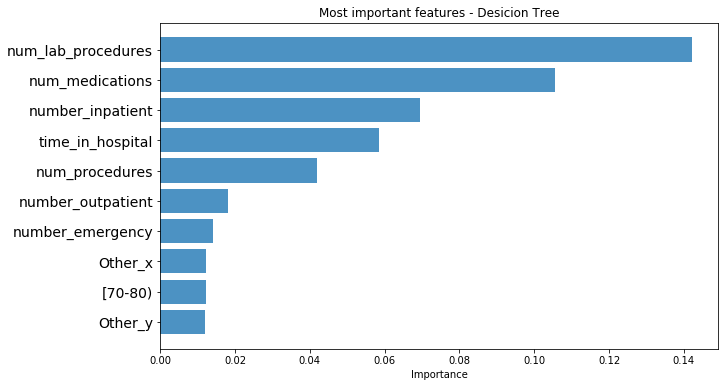

                Feature  Importance
53              Other_y    0.012087
15              [70-80)    0.012198
44              Other_x    0.012298
137    number_emergency    0.014123
136   number_outpatient    0.018006
134      num_procedures    0.041836
132    time_in_hospital    0.058401
138    number_inpatient    0.069419
135     num_medications    0.105613
133  num_lab_procedures    0.142062


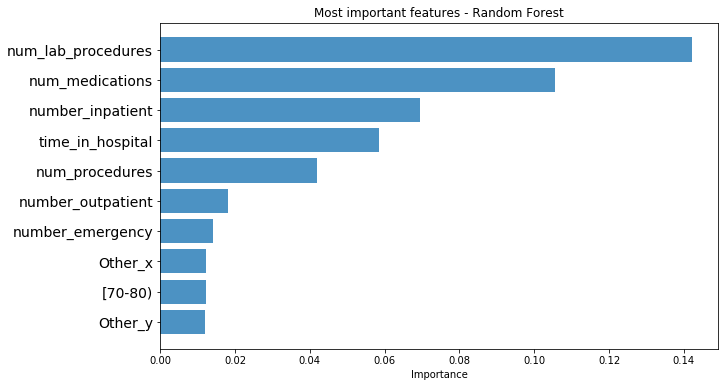

In [31]:
# Selección de variables: se crea una lista de la 10 variables más importantes ordenadas por relevancia
# Desicion Tree
feature_names = x_train1.columns
feature_imports = model1.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Desicion Tree')
plt.show()
# Random Forest
feature_names = x_train1.columns
feature_imports = model1.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()

### 3.3 Medición de desempeño del modelo

              precision    recall  f1-score   support

           0       0.60      0.62      0.61     10738
           1       0.53      0.51      0.52      9161

    accuracy                           0.57     19899
   macro avg       0.56      0.56      0.56     19899
weighted avg       0.57      0.57      0.57     19899

              precision    recall  f1-score   support

           0       0.62      0.68      0.65     10738
           1       0.58      0.52      0.55      9161

    accuracy                           0.61     19899
   macro avg       0.60      0.60      0.60     19899
weighted avg       0.60      0.61      0.60     19899

              precision    recall  f1-score   support

           0       0.62      0.78      0.69     10738
           1       0.63      0.44      0.52      9161

    accuracy                           0.62     19899
   macro avg       0.63      0.61      0.61     19899
weighted avg       0.63      0.62      0.61     19899



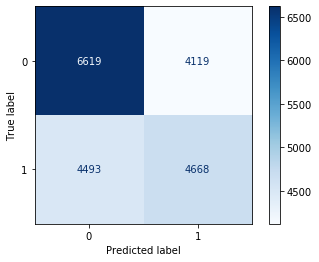

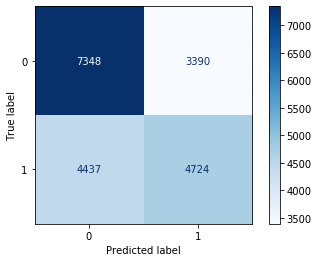

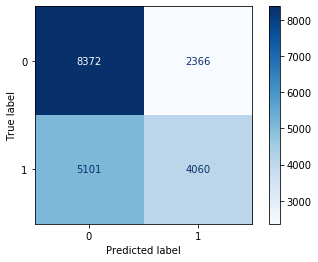

In [29]:
# Genera la matriz de confusión y las métricas (precision, recall, f1 score, accuracy)
#Desicion Tree
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(model1, x_test1, y_test1,values_format = 'd',cmap = 'Blues') 
print(metrics.classification_report(y_test1, y_pred1))

#Random Frest
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(model2, x_test2, y_test2,values_format = 'd',cmap = 'Blues') 
print(metrics.classification_report(y_test2, y_pred2))

#Logistic Regression
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(model3, x_test3, y_test3,values_format = 'd',cmap = 'Blues') 
print(metrics.classification_report(y_test3, y_pred3))